## Bayesian Optimziation for RAPID

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Load the experimental film data

In [3]:
########## Read in excel file ##########

# df_film = pd.read_excel('/Users/matt/Desktop/RAPID optimization/SL-PerovskiteOpt/ML_perovskite_data.xlsx', sheet_name='PVK Data')
df_film = pd.read_excel(
    "/groups/aprintz/github/SL-PerovskiteOpt/RAPID Optimization/ML_perovskite_data.xlsx",
    sheet_name="PVK Data",
)

df_film.columns = [
    "ML Condition",
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "volume used [uL]",
    "Confinement gap [um]",
    "% DMSO",
    "Temp Substrate [\N{DEGREE SIGN}C]",
    "Post Anneal time [m]",
    "Success or Fail",
    "Notes",
    "Where to find",
]
########## Get successful processing conditions ##########

success_conditions = df_film[df_film["Success or Fail"] == 1]["ML Condition"].values

########## Define processing variables to include ##########

included_vars = [
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Confinement gap [um]",
    "% DMSO",
    "Temp Substrate [\N{DEGREE SIGN}C]",
    "Post Anneal time [m]",
]

########## Define new dataframe with only included processing variables ##########

df_included_vars = df_film[included_vars]
df_included_vars

,Molarity [M],Temperature [°C],Speed [m/min],Confinement gap [um],% DMSO,Temp Substrate [°C],Post Anneal time [m]
0,0.4,100,1.0,100,10,150,5
1,0.4,100,0.5,100,10,150,5
2,0.4,100,1.0,100,20,150,5
3,0.4,100,0.5,100,20,150,5
4,0.4,100,1.0,100,30,150,5
...,...,...,...,...,...,...,...
103,1.2,100,0.5,100,40,150,5
104,1.2,100,1.0,100,60,150,5
105,1.2,100,0.5,100,60,150,5
106,1.2,100,1.0,100,80,150,5


# Set the variable space of process conditions

In [4]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

precursor_min, precursor_max, precursor_step = [
    0.4,
    2,
    0.2,
]  # Unit: concentration ## 4 steps
precursor_var = np.arange(precursor_min, precursor_max + precursor_step, precursor_step)
precursor_num = len(precursor_var)

super_temp_min, super_temp_max, super_temp_step = [
    50,
    200,
    5,
]  ## Unit: degC ## 30 steps
super_temp_var = np.arange(
    super_temp_min, super_temp_max + super_temp_step, super_temp_step
)
super_temp_num = len(super_temp_var)

speed_min, speed_max, speed_step = [0.5, 3, 0.5]  ## Unit: m/min ## 9 steps
speed_var = np.arange(speed_min, speed_max + speed_step, speed_step)
speed_num = len(speed_var)

dist_min, dist_max, dist_step = [25, 200, 5]  ## Unit: microns ## 7 steps
dist_var = np.arange(dist_min, dist_max + dist_step, dist_step)
dist_num = len(dist_var)

dmso_min, dmso_max, dmso_step = [0, 100, 5]  # Unit: %DMSO ## 3 steps
dmso_var = np.arange(dmso_min, dmso_max + dmso_step, dmso_step)
dmso_num = len(dmso_var)

sub_temp_min, sub_temp_max, sub_temp_step = [50, 200, 5]  ## Unit: degC ## 30 steps
sub_temp_var = np.arange(sub_temp_min, sub_temp_max + sub_temp_step, sub_temp_step)
sub_temp_num = len(sub_temp_var)

anneal_min, anneal_max, anneal_step = [0, 10, 2.5]  ## Unit: Minutes ## 5 steps
anneal_var = np.arange(anneal_min, anneal_max + anneal_step, anneal_step)
anneal_num = len(anneal_var)


########## Create process variable array ##########
var_array = [
    precursor_var,
    super_temp_var,
    speed_var,
    dist_var,
    dmso_var,
    sub_temp_var,
    anneal_var,
]

########## Create labels for process variable array, making sure order is same as var_array ##########
x_labels = [
    "Precursor Concentration [M]",
    "Superstrate Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Working Distance [\N{greek small letter mu}m]",
    "DMSO Concentration [%v/v]",
    "Substrate Temperature [\N{DEGREE SIGN}C]" "Post Annealing Time [min]",
]


def x_normalizer(X):

    def max_min_scaler(x, x_max, x_min):
        return (x - x_min) / (x_max - x_min)

    x_norm = []
    for x in X:
        x_norm.append(
            [
                max_min_scaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_norm)


def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x * (x_max - x_min) + x_min

    x_original = []
    for x in x_norm:
        x_original.append(
            [
                max_min_rescaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_original)

def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value: abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value

    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append(
            [get_closest_value(x[i], var_list[i]) for i in range(len(x))]
        )
    return np.array(modified_array)

### Define Bayes-Opt variable space from above processing conditions. Only edit if variables added/removed. Make sure the order and number of variables is consistent!

In [5]:
# Bounded region of parameter space
parameter_space = {"Precursor Concentration":
                        (0 - 1 / (precursor_num - 1) / 2,
                        1 + 1 / (precursor_num - 1) / 2), 
                   "SuperTemp": 
                       (0 - 1 / (super_temp_num - 1) / 2,
                        1 + 1 / (super_temp_num - 1) / 2),
                   "Speed": 
                       (0 - 1 / (speed_num - 1) / 2, 
                        1 + 1 / (speed_num - 1) / 2),
                   "Distance": 
                       (0 - 1 / (dist_num - 1) / 2,
                        1 + 1 / (dist_num - 1) / 2),
                   "DMSO": 
                       (0 - 1 / (dmso_num - 1) / 2,
                        1 + 1 / (dmso_num - 1) / 2),
                   "SubTemp": 
                       (0 - 1 / (sub_temp_num - 1) / 2,
                        1 + 1 / (sub_temp_num - 1) / 2),
                   "AnnealTime": 
                       (0 - 1 / (anneal_num - 1) / 2,
                        1 + 1 / (anneal_num - 1) / 2)
                   }

# Bayesian Optimization 

## Enter experimental design loop

In [6]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.gaussian_process.kernels import Matern

x_init = x_normalizer(df_included_vars.to_numpy()) # Normalize experimental data 
y_init = np.transpose([df_film["Success or Fail"].to_numpy()]) # Get array of pass/fail conditions
X, Y = [x_init, y_init.ravel()] # Flatten output dimensions to (N,) and convert variables to statistics standard Y(X)

input_dim = len(X[0])  # Get number of variables in space

# Create Bayes Opt Optimizer Instance
optimizer = BayesianOptimization(f=None, #real-world function
                                 pbounds=parameter_space, #parameter space above
                                 random_state=42, #to make it reproducible
                                 allow_duplicate_points=True) #dont stop optimizer when duplicate points are suggested

# replace optimizer kernel to nonisotropic Matern 5/2. Needed for multidimensional Bayesian Optimization.
kernel = 2.0 * Matern(nu=2.5,
            length_scale=np.ones(len(parameter_space)), # default = 1.0
            # length_scale_bounds=(1e-1, 1e5)
            )

optimizer.set_gp_params(kernel=kernel,
                        alpha=1e-3, 
                        n_restarts_optimizer=50,
                        random_state=42,
                        )
print(optimizer._gp.get_params())

df_X = pd.DataFrame(X, columns=parameter_space.keys())
current_observations = df_X.to_dict('records')

for i, observer_dict in enumerate(current_observations):
    # print(observer_dict)
    # print(Y[i])
    optimizer.register( # get initial data. Inputs need to be of form list({'AnnealTime': 0.3431751485592031, 'DMSO': 0.9732500217304118, 'Distance': 0.7386223401488737, 'Precursor Concentration': 0.6109907947216662, 'Speed': 0.08722236853092386, 'SubTemp': 0.14452767101407604, 'SuperTemp': 0.04335306590713944})
        params=observer_dict,
        target=Y[i],
    )


{'alpha': 0.001, 'copy_X_train': True, 'kernel__k1': 1.41**2, 'kernel__k2': Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5), 'kernel__k1__constant_value': 2.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': array([1., 1., 1., 1., 1., 1., 1.]), 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel__k2__nu': 2.5, 'kernel': 1.41**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5), 'n_restarts_optimizer': 50, 'n_targets': None, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42}
Data point [0.5        0.1        0.42857143 0.         0.2        0.66666667
 0.33333333] is not unique. 1 duplicates registered. Continuing ...
Data point [0.5        0.1        0.42857143 0.         0.         0.66666667
 0.33333333] is not unique. 2 duplicates registered. Continuing ...
Data point [0.5        0.2        0.42857143 0.         0.2        0.66666667
 0.33333333] is not unique. 3 duplicates registered. Continuing ...
Data point 

## Visualize underlying GP process

/home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


all rmse: 0.3043
all R^2: 0.6190
all spearman: 0.8142


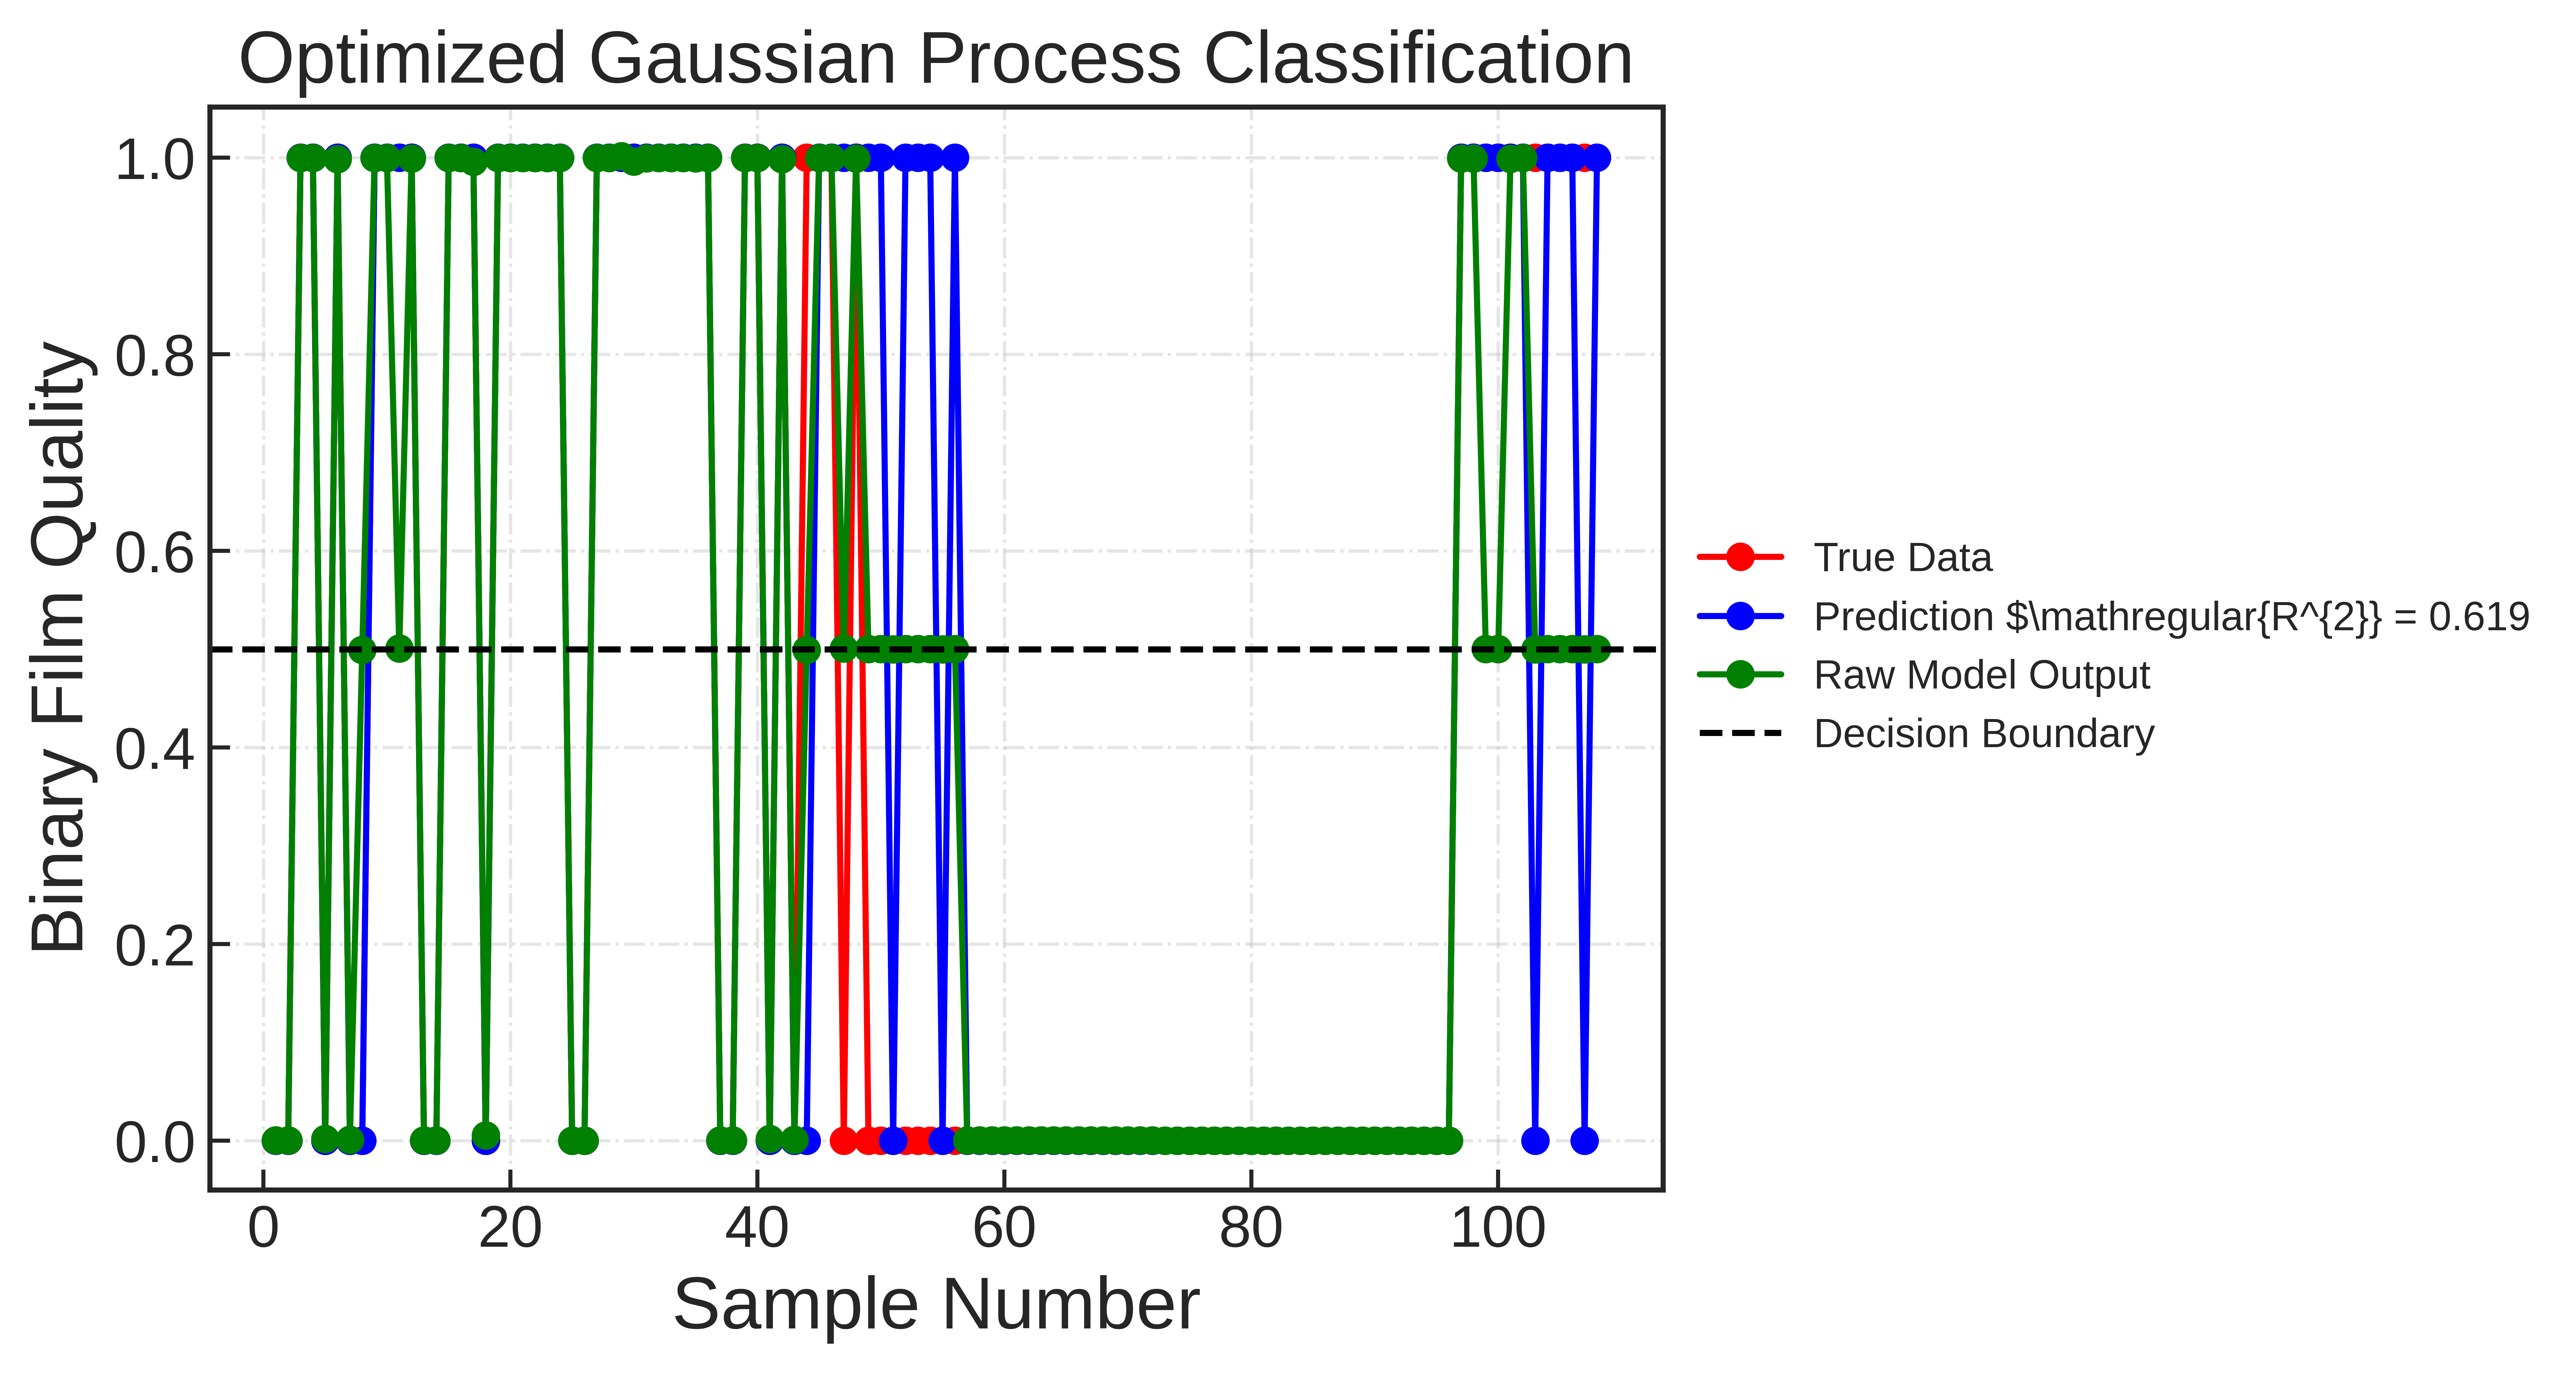

In [7]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
from matplotlib import style
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

style.use('default') # Complete reset the matplotlib figure style
style.use('seaborn-v0_8-ticks') # use one of the existing matplotlib style sheet

optimizer._gp.fit(X, Y)
y_pred = optimizer._gp.predict(X)

# Convert probabilities to binary predictions since model outputs contineous data in the space [0,1]
threshold = 0.5  # Above threshold, pass. Below threshold, fail.
y_pred_binary = (y_pred > threshold).astype(int)

fontsize = 18
lims = (-0.1, 1.1)

mse = mean_squared_error
mse_all = mse(Y, y_pred_binary)
print("all rmse: %.4f" % (np.sqrt(mse_all)))

rsquared_all = r2_score(Y, y_pred_binary)
print("all R^2: %.4f" % (rsquared_all))

sprman_all = spearmanr(Y, y_pred_binary)
print("all spearman: %.4f" % (sprman_all[0]))

# Plot the true input data and the prediction against the data point number
plt.figure(dpi=1000)
sample_array = np.array(range(1, len(Y) + 1))
plt.plot(range(1, len(Y) + 1), Y, "ro-", label="True Data")
plt.plot(range(1, len(Y) + 1), y_pred_binary, "bo-", label="Prediction $\mathregular{R^{2}} = " + f"{round(rsquared_all, 3)}")
plt.plot(range(1, len(Y) + 1), y_pred, "go-", label="Raw Model Output")
plt.axhline(y=0.5, c='black', linestyle='dashed', label="Decision Boundary")

title = "Optimized Gaussian Process Classification"
plt.xlabel("Sample Number", fontsize=fontsize)
plt.ylabel("Binary Film Quality", fontsize=fontsize)
plt.title(title, fontsize=fontsize)
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.tick_params(
    direction="in", length=5, width=1, labelsize=fontsize * 0.8, grid_alpha=0.5
)
plt.grid(True, linestyle="-.")

## Experimental design loop

In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from IPython.display import display
from bayes_opt.util import load_logs
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.gaussian_process.kernels import Matern
cm = sns.diverging_palette(-5, 5, as_cmap=True)


num_experiments = 10 #to avoid an infinite loop. The model will perform this many experiment steps before stopping
log_path = "/groups/aprintz/github/SL-PerovskiteOpt/RAPID Optimization/new_x_results.json" # set this to the absolute path of the logfile.


x_init = x_normalizer(df_included_vars.to_numpy()) # Normalize experimental data 
y_init = np.transpose([df_film["Success or Fail"].to_numpy()]) # Get array of pass/fail conditions
X, Y = [x_init, y_init.ravel()] # Flatten output dimensions to (N,) and convert variables to statistics standard Y(X)
input_dim = len(X[0])  # Get number of variables in space

# Create Bayes Opt Optimizer Instance
optimizer = BayesianOptimization(f=None, #real-world function
                                 pbounds=parameter_space, #parameter space above
                                 random_state=42, #to make it reproducible
                                 allow_duplicate_points=True) #dont stop optimizer when duplicate points are suggested

# replace optimizer kernel to nonisotropic Matern 5/2. Needed for multidimensional Bayesian Optimization.
kernel = 2.0 * Matern(nu=2.5,
            length_scale=np.ones(len(parameter_space)), # default = 1.0
            # length_scale_bounds=(1e-1, 1e5)
            )

optimizer.set_gp_params(kernel=kernel,
                        alpha=1e-3, 
                        n_restarts_optimizer=50,
                        random_state=42,
                        )
# print(optimizer._gp.get_params())

df_X = pd.DataFrame(X, columns=parameter_space.keys())
current_observations = df_X.to_dict('records')

for i, observer_dict in enumerate(current_observations):
    # print(observer_dict)
    # print(Y[i])
    optimizer.register( # get initial data. Inputs need to be of form list({'AnnealTime': 0.3431751485592031, 'DMSO': 0.9732500217304118, 'Distance': 0.7386223401488737, 'Precursor Concentration': 0.6109907947216662, 'Speed': 0.08722236853092386, 'SubTemp': 0.14452767101407604, 'SuperTemp': 0.04335306590713944})
        params=observer_dict,
        target=Y[i],
    )

# Highlight the last row
def highlight_last(s):
  return ['background-color: yellow' if x == -1 else '' for x in s.index]

try:# New optimizer is loaded with previously seen points
    load_logs(optimizer, logs=log_path)
    print(f"Successfully loaded logs at: {log_path}")
except: 
    print(f"Unable to load logs at: {log_path}")
    
logger = JSONLogger(path=log_path, reset=False)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1) low kappa,xi = explore near peaks, high = exlore elsewhere
# acquisition_function = UtilityFunction(kind="poi", xi=1e-1)
acquisition_function = UtilityFunction(kind="ei", xi=1e-2) #recommended starting valie of xi = 0.01

X_new_list = []

i = 0
stop_loop = False
while i < num_experiments:
    next_point = optimizer.suggest(acquisition_function)
    X_new = [list(next_point.values())]
    X_new = get_closest_array(x_denormalizer(X_new)) # make sure variable array is correct!
    X_new_list.append(X_new.ravel().tolist())
    df_X_new = pd.DataFrame(X_new_list, columns=included_vars)
    
    df_X_new.style.background_gradient(cmap=cm, axis=1, subset=df_X_new.index[-1])
    display(df_X_new.style.background_gradient(cmap=cm, axis=1, subset=df_X_new.index[-1]), clear=True)
    
    while True:
        user_input = input("Enter 0, 1, or 'q' to quit: ")
        try:
        # Try converting the input to an integer
            user_input = int(user_input)
            if user_input in (0, 1):
                # Valid integer input (0 or 1)
                print(f"You entered: {user_input}")
                break  # Exit the loop if valid input is received
            else:
                print("Invalid integer input. Please enter 0 or 1.")
        except ValueError:
            # Not a valid integer, check if it's 'q'
            if user_input.lower() == 'q':
                print("Exiting...")
                stop_loop = True
                break  # Exit the loop if 'q' is entered
            else:
                print("Invalid input. Please enter 0, 1, or 'q' to quit.")
        
    if stop_loop:
        break  # Exit the loop if 'q' is entered
            
    optimizer.register(params=next_point, target=np.float32(user_input))

,Precursor Molarity [M],Superstrate Temperature [°C],Speed [m/min],Confinement Gap [um],% DMSO,Substrate Temperature [°C],Post Anneal Time [m]
0,1.200000,95.000000,1.500000,25.000000,0.000000,130.000000,2.500000
1,1.200000,95.000000,1.000000,70.000000,35.000000,160.000000,2.500000


Exiting...
